# Pipelines: Processing Numeric and Categorical Data

* A fixed sequence of steps in processing the data, for example feature selection, normalization and classification.

* Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply, in a specific order.  

* Scikit-Learn provides the Pipeline class to help with such sequences of transformations. 

* In addition, using a column selector a pipeline can be configured to choose which columns get which transformations. The transformations happen in parallel. The results of each are then concatenated together.

## Depiction of pipeline for Processing Mixed Data Types¶.
![Example Pipeline with Feature Union](pipeline_example.jpg "Pipeline Mixed Data Types")

Useful:  dataset is stored in a Pandas DataFrame and different columns require different processing pipelines. 

## Examples below use scikit-learn v0.20.0

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder  # NOTE: using scikit-learn v0.20.0
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier

import nbextensions

import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set(rc={"figure.figsize": (12, 8)})
%load_ext line_profiler
from sklearn.utils import resample

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [10]:
# Load the data
df = pd.read_csv('http://www.chalendony.de/application_train.csv')

In [11]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Preparation

In [12]:
# Remove the identifier column
df.drop(['SK_ID_CURR'], inplace=True, axis=1)

## Numerical and categorical attributes

In [13]:
categorical_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE', \
                        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE',\
                        'FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS',\
                        'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START',\
                        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',\
                        'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3',\
                        'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',\
                        'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',\
                        'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',\
                        'EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']

numerical_features = df.columns.difference(categorical_features).values.tolist()
numerical_features.remove('TARGET')

print('categorical({}) '.format(len(categorical_features)))
print('numeric({})'.format(len(numerical_features)))

categorical(52) 
numeric(68)


## Assign data types

In [14]:
# Numerical column types are defaulted to floats
df[numerical_features] = df[numerical_features].astype("float")
df['TARGET'] = df['TARGET'].astype("float")

# Categorical features can't be set all at once
for f in categorical_features:
    df[f] = df[f].astype("category")

    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(52), float64(69)
memory usage: 177.1 MB


## Create train and test sets: 

In [15]:
# Partition data set into training/test using Stratefied split to maintain distribution - 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df,df["TARGET"]):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]
    

In [7]:
## are there nan in the target
X_train

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
181648,0,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
229245,0,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,135000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
122525,1,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,553500.0,...,0,0,0,0,0.0,0.0,2.0,0.0,0.0,2.0
306311,1,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,391500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
300658,0,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
201033,0,Revolving loans,F,N,Y,0,74250.0,225000.0,11250.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,3.0,1.0,2.0
86445,0,Cash loans,M,Y,N,1,157500.0,360000.0,13842.0,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
225267,0,Cash loans,F,N,Y,1,202500.0,1350189.0,39609.0,1179000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
42927,0,Cash loans,F,N,N,1,81000.0,225000.0,10953.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
240820,0,Revolving loans,M,Y,Y,0,112500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0


## Downsample Majority Class

In [16]:
## downsample majority class
df_majority = X_train[X_train.TARGET==0]
df_minority = X_train[X_train.TARGET==1]
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
X_train = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
X_train.TARGET.value_counts()

1.0    19860
0.0    19860
Name: TARGET, dtype: int64

## Check value of targets

In [9]:
pd.DataFrame(X_train.loc[X_train.index].TARGET)

,TARGET
127014,0
46214,0
153845,0
70434,0
102367,0
302719,0
51874,0
134163,0
216434,0
110409,0


# Pop target from the training and test sets

In [17]:
# pop target from the training and test sets
train_index = X_train.index
y_train = pd.DataFrame(X_train.loc[train_index].TARGET)
y_test = X_test.TARGET[test_index]

print(y_train.shape)
print(y_test.shape)
X_train.drop('TARGET', inplace=True, axis=1)
X_test.drop('TARGET', inplace=True, axis=1)

(39720, 1)
(61503,)


# Option 1: Pipeline with ColumnTransformer

Applies transformers to columns of an array or pandas DataFrame.

EXPERIMENTAL: some behaviors may change between releases without deprecation.

This estimator allows different columns or column subsets of the input to be transformed separately and the results combined into a single feature space. 

List consisting of 3-Tuples: (name, transformer, columns)

In [ ]:
# Create Steps for a Pipeline

# Steps for Categorical Features
#cat_si_step = ('si', SimpleImputer(strategy="most_frequent", verbose=1))
#cat_ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
#cat_steps = [cat_si_step, cat_ohe_step]
#cat_pipe = Pipeline(cat_steps)
#cat_transformers = [('cat', cat_pipe, categorical_features)]

## numeric features ...

#ct = ColumnTransformer(transformers=cat_transformers)
#X_cat_transformed = ct.fit_transform(X_train)

In [12]:
numerical_features

['AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AMT_INCOME_TOTAL',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'CNT_CHILDREN',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_REGISTRATION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVI

best logistic regression from grid search: 0.658


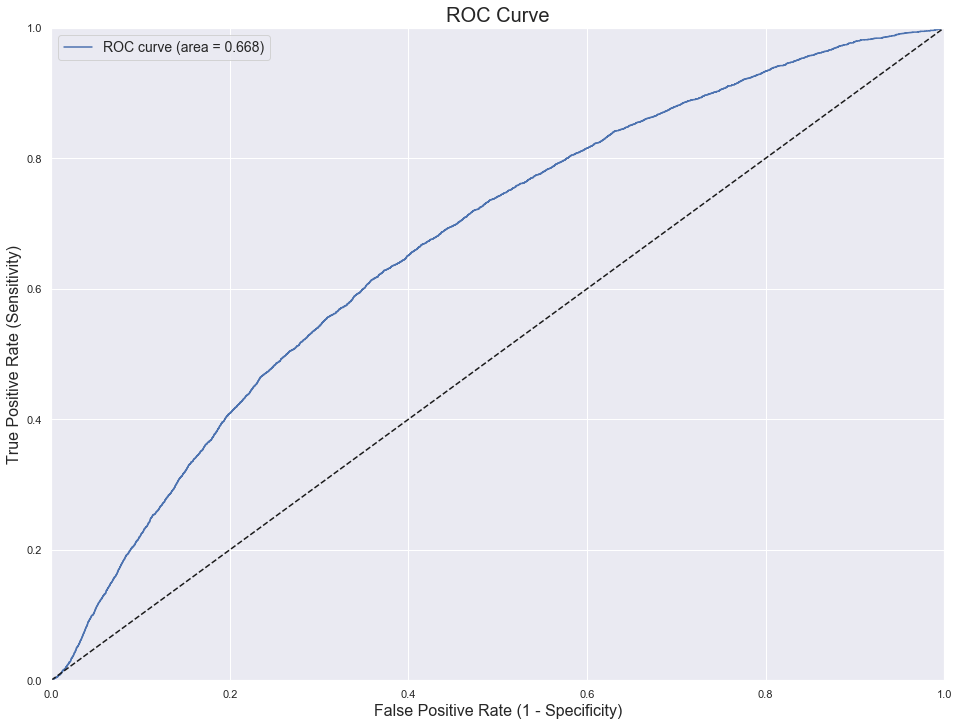

In [28]:
# numeric preprocessing 
numeric_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(verbose=1)),
    ('scaler', StandardScaler())
    ])

# categorical preprocessing
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# column transformer : numerical and categorical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# append classifier to preprocessing pipeline to get a full prediction pipeline
clf = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', SGDClassifier(loss="hinge", max_iter=5, shuffle=True))
        
           
          ])

# set up grid search
param_grid = {
    'preprocessor__num__imputer__strategy': ['median'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'], 
}

grid_search = GridSearchCV(clf, param_grid, cv=2)
grid_search.fit(X_train, y_train.values.ravel())
y_score = grid_search.decision_function(X_test)


print(("best logistic regression from grid search: %.3f" % grid_search.score(X_test, y_test.values.ravel())))


fpr, tpr, thresholds = roc_curve(y_test.values, y_score)
roc_auc = roc_auc_score(y_test.values, y_score)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

create stratified and use it in grid search

https://gist.github.com/tobigue/3188762

# Option 2: Pipeline with FeatureUnion

## Exmple : Defining Pipeline Transformers (i.e.: Steps in a Pipeline)

In [11]:
# Estimator to select columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

# Estimator to select data types
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

## Build Pre-processing Pipeline

In [21]:
#  Pre-processing Pipeline
x_cols = [*X_train.columns.values]
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.float64),
            SimpleImputer(strategy="median", verbose=1),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="most_frequent", verbose=1),
            OneHotEncoder(sparse=False, handle_unknown='ignore')
        ))
    ])
)

# Classification pipeline
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    #SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    SVC(gamma = 'auto', kernel="rbf", random_state=42)
)

param_grid = {
    "svc__gamma": ['auto'], "svc__kernel": ['rbf'] 
}

In [110]:
%%timeit -n 1 -r 1 -t x = range(10)
model = classifier_pipeline.fit(X_train, y_train.values.ravel())

/Users/stewarta/anaconda3/envs/wrangle_env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


9min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Using FeatureUnion Pipeline to Build a Model

29min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


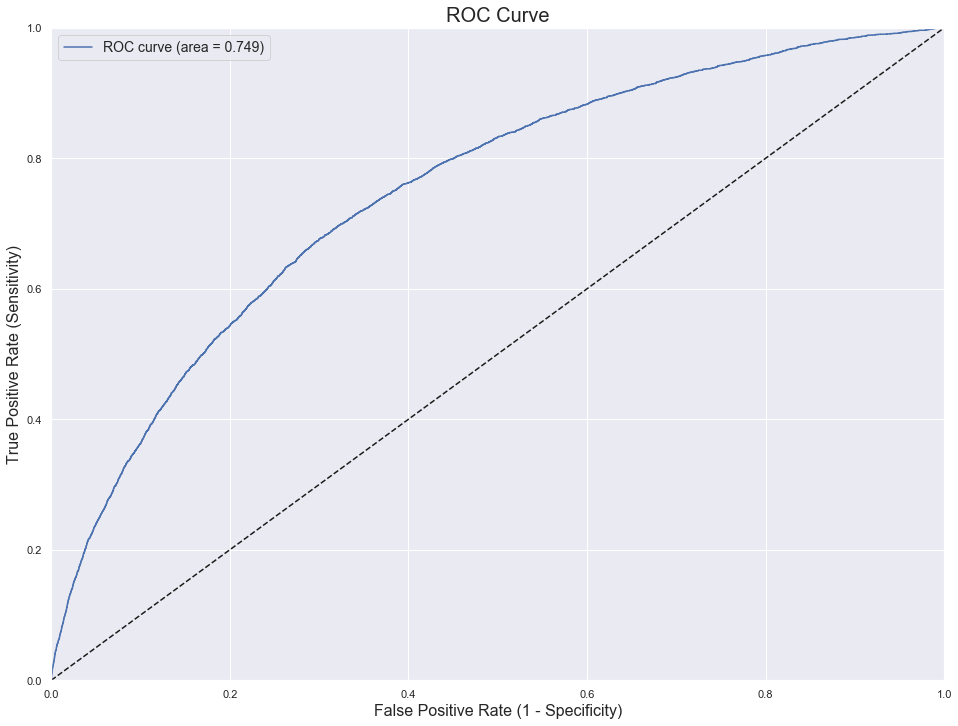

In [124]:
%%timeit -n 1 -r 1 -t x = range(10)
classifier_model = GridSearchCV(classifier_pipeline, param_grid, cv=2)
classifier_model.fit(X_train, y_train.values.ravel())

y_score = classifier_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test.values, y_score)
roc_auc = roc_auc_score(y_test.values, y_score)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

## Exercises

* Consider modifying numeric pipeling to include Binning numeric columns with the new KBinsDiscretizer
https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62

* Advantages and disadvantages of balancing the data by up-sampling. 
https://elitedatascience.com/imbalanced-classes

* Accessing  elements of the gridsearch, plotting all curves of the grid search, criteria used to determine best grid search score.

* Accessing  elements of the ColumnTransform

* comparison of FeatureUnion and ColumnTransform : time, readability, choice of classifier is making a difference in run time